In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy as sp
import skimage.filters as skf
import sys
import warnings
import numexpr as ne
from scipy import optimize as sio
from scipy import ndimage as scnd
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import SI_LENGTH_RECIPROCAL
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
import math
import sys
import numba
import pyfftw
from skimage.transform import rescale as skitres
%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'font.weight': 'bold'})

In [2]:
warnings.filterwarnings('ignore')
#sys.path.append('/home/cades/Codes/stemtools')
sys.path.append('/home/cades/Codes/stemtools')
import stemtools as st
%load_ext autoreload
%autoreload 2

In [17]:
def get_flat_dpc(data4D_flat,centered=True):
    if centered:
        beam_x = data4D_flat.shape[1]
        beam_y = data4D_flat.shape[0]
    else:
        CentralDisk = np.median(data4D_flat,axis=0)
        beam_x,beam_y,_ = st.util.sobel_circle(CentralDisk)
    yy, xx = np.mgrid[0:data4D_flat.shape[1],0:data4D_flat.shape[2]]
    FlatSum = np.sum(data4D_flat,axis=(-1,-2))
    FlatY = np.multiply(data4D_flat,yy)
    FlatX = np.multiply(data4D_flat,xx)
    YCom = (np.sum(FlatY,axis=(-1,-2))/FlatSum) - beam_x
    XCom = (np.sum(FlatX,axis=(-1,-2))/FlatSum) - beam_y
    return XCom,YCom

def cart2pol(x, y):
    rho = ne.evaluate("((x**2) + (y**2)) ** 0.5")
    phi = ne.evaluate("arctan2(y, x)")
    return (rho, phi)

def pol2cart(rho, phi):
    x = ne.evaluate("rho * cos(phi)")
    y = ne.evaluate("rho * sin(phi)")
    return (x, y)

def angle_fun(angle,rho_dpc,phi_dpc):
    x_dpc,y_dpc = pol2cart(rho_dpc,(phi_dpc + (angle*((np.pi)/180))))
    charge = np.gradient(x_dpc)[1] + np.gradient(y_dpc)[0]
    angle_sum = np.sum(np.abs(charge))
    return angle_sum

def optimize_angle(x_dpc,y_dpc,adf_stem):
    flips = np.zeros(4,dtype=bool)
    flips[2:4] = True
    chg_sums = np.zeros(4,dtype=x_dpc.dtype)
    angles = np.zeros(4,dtype=x_dpc.dtype)
    x0 = 90
    for ii in range(2):
        to_flip = flips[2*ii]
        if to_flip:
            xdpcf = np.flip(x_dpc)
        else:
            xdpcf = x_dpc
        rho_dpc,phi_dpc = cart2pol(xdpcf,y_dpc)
        x = sio.minimize(angle_fun,x0,args=(rho_dpc,phi_dpc))
        min_x = x.x
        sol1 = min_x - 90
        sol2 = min_x + 90
        chg_sums[int(2*ii)] = np.sum(charge_dpc(xdpcf,y_dpc,sol1)*adf_stem)
        chg_sums[int(2*ii+1)] = np.sum(charge_dpc(xdpcf,y_dpc,sol2)*adf_stem)
        angles[int(2*ii)] = sol1
        angles[int(2*ii+1)] = sol2
    angle = (-1)*angles[chg_sums==np.amin(chg_sums)][0]
    final_flip = flips[chg_sums==np.amin(chg_sums)][0]
    return angle, final_flip

def corrected_dpc(x_dpc,y_dpc,angle,flipper):
    if flipper:
        xdpcf = np.fliplr(x_dpc)
    else:
        xdpcf = np.copy(x_dpc)
    rho_dpc,phi_dpc = cart2pol(xdpcf,y_dpc)
    x_dpc2,y_dpc2 = pol2cart(rho_dpc,(phi_dpc - (angle*((np.pi)/180))))
    return x_dpc2,y_dpc2

def potential_dpc(x_dpc,y_dpc,angle=0):
    if angle==0:
        potential = integrate_dpc(x_dpc,y_dpc)
    else:
        rho_dpc,phi_dpc = cart2pol(x_dpc,y_dpc)
        x_dpc,y_dpc = pol2cart(rho_dpc,phi_dpc + (angle*((np.pi)/180)))
        potential = integrate_dpc(x_dpc,y_dpc)
    return potential

def charge_dpc(x_dpc,y_dpc,angle=0):
    if angle==0:
        charge = np.gradient(x_dpc)[1] + np.gradient(y_dpc)[0]
    else:
        rho_dpc,phi_dpc = cart2pol(x_dpc,y_dpc)
        x_dpc,y_dpc = pol2cart(rho_dpc,phi_dpc + (angle*((np.pi)/180)))
        charge = np.gradient(x_dpc)[1] + np.gradient(y_dpc)[0]
    return charge

def integrate_dpc(xshift,
                  yshift,
                  fourier_calibration=1):
    #Initialize matrices
    size_array = np.asarray(np.shape(xshift))
    x_mirrored = np.zeros(2*size_array,dtype=np.float64)
    y_mirrored = np.zeros(2*size_array,dtype=np.float64)
    
    #Generate antisymmetric X arrays
    x_mirrored[0:size_array[0],0:size_array[1]] = np.fliplr(np.flipud(0 - xshift))
    x_mirrored[0:size_array[0],size_array[1]:(2*size_array[1])] = np.fliplr(0 - xshift)
    x_mirrored[size_array[0]:(2*size_array[0]),0:size_array[1]] = np.flipud(xshift)
    x_mirrored[size_array[0]:(2*size_array[0]),size_array[1]:(2*size_array[1])] = xshift
    
    #Generate antisymmetric Y arrays
    y_mirrored[0:size_array[0],0:size_array[1]] = np.fliplr(np.flipud(0 - yshift))
    y_mirrored[0:size_array[0],size_array[1]:(2*size_array[1])] = np.fliplr(yshift)
    y_mirrored[size_array[0]:(2*size_array[0]),0:size_array[1]] = np.flipud(0 - yshift)
    y_mirrored[size_array[0]:(2*size_array[0]),size_array[1]:(2*size_array[1])] = yshift
    
    #Calculated Fourier transform of antisymmetric matrices
    x_mirr_ft = np.fft.fft2(x_mirrored)
    y_mirr_ft = np.fft.fft2(y_mirrored)
    
    #Calculated inverse Fourier space calibration
    qx = np.mean(np.diff((np.arange(-size_array[1],size_array[1], 1))/
                         (2*fourier_calibration*size_array[1])))
    qy = np.mean(np.diff((np.arange(-size_array[0],size_array[0], 1))/
                         (2*fourier_calibration*size_array[0])))
    
    #Calculate mirrored CPM integrand
    mirr_ft = (x_mirr_ft + ((1j)*y_mirr_ft))/(qx + ((1j)*qy))
    mirr_int = np.fft.ifft2(mirr_ft)
    
    #Select integrand from antisymmetric matrix
    integrand = np.abs(mirr_int[size_array[0]:(2*size_array[0]),size_array[1]:(2*size_array[1])])
    
    return integrand

@numba.jit(cache=True,parallel=True)
def centerCBED(data4D_flat,
               x_cen,
               y_cen):
    pyfftw.interfaces.cache.enable()
    image_size = np.asarray(data4D_flat.shape[1:3])
    moved_pattern = np.zeros_like(data4D_flat,dtype=data4D_flat.dtype)
    fourier_cal_y = (np.linspace((-image_size[0]/2), ((image_size[0]/2) - 1), image_size[0]))/image_size[0]
    fourier_cal_x = (np.linspace((-image_size[1]/2), ((image_size[1]/2) - 1), image_size[1]))/image_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    move_pixels = np.flip(image_size/2) - np.asarray((x_cen,y_cen))
    move_phase = np.exp((-2) * np.pi * 1j * ((fourier_mesh_x*move_pixels[0]) + (fourier_mesh_y*move_pixels[1])))
    for ii in numba.prange(data4D_flat.shape[0]):
        fft_cbd = np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(data4D_flat[ii,:,:]))
        moved_pattern[ii,:,:] = np.abs(pyfftw.interfaces.numpy_fft.ifft2(np.multiply(fft_cbd,move_phase)))
    return moved_pattern

@numba.jit(cache=True)
def resizer1D_numbaopt(data,res,N):   
    M = data.size
    carry=0
    m=0
    for n in range(int(N)):
        data_sum = carry
        while m*N - n*M < M :
            data_sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        data_sum -= carry
        res[n] = data_sum*N/M
    return res

@numba.jit(cache=True)
def resizer2D(data2D,sampling):
    data_shape = np.asarray(np.shape(data2D))
    sampled_shape = (np.round(data_shape/sampling)).astype(int)
    resampled_x = np.zeros((data_shape[0],sampled_shape[1]),dtype=data2D.dtype)
    resampled_f = np.zeros(sampled_shape,dtype=data2D.dtype)
    for yy in range(data_shape[0]):
        resampled_x[yy,:] = resizer1D_numbaopt(data2D[yy,:],resampled_x[yy,:],sampled_shape[1])
    for xx in range(sampled_shape[1]):
        resampled_f[:,xx] = resizer1D_numbaopt(resampled_x[:,xx],resampled_f[:,xx],sampled_shape[0])
    return resampled_f

@numba.jit(cache=True)
def resizer2D_numbaopt(data2D,resampled_x,resampled_f,sampling):
    data_shape = np.asarray(np.shape(data2D))
    sampled_shape = (np.round(data_shape/sampling)).astype(int)
    for yy in range(data_shape[0]):
        resampled_x[yy,:] = resizer1D_numbaopt(data2D[yy,:],resampled_x[yy,:],sampled_shape[1])
    for xx in range(sampled_shape[1]):
        resampled_f[:,xx] = resizer1D_numbaopt(resampled_x[:,xx],resampled_f[:,xx],sampled_shape[0])
    return resampled_f

@numba.jit(cache=True,parallel=True)
def resizer4Df(data4D_flat,sampling):
    datashape = np.asarray(data4D_flat.shape)
    res_shape = np.copy(datashape)
    res_shape[1:3] = np.round(datashape[1:3]/sampling)
    data4D_res = np.zeros(res_shape.astype(int),dtype=data4D_flat.dtype)
    resampled_x = np.zeros((datashape[1],res_shape[2]),data4D_flat.dtype)
    resampled_f = np.zeros(res_shape[1:3],dtype=data4D_flat.dtype)
    for zz in numba.prange(data4D_flat.shape[0]):
        data4D_res[zz,:,:] = resizer2D_numbaopt(data4D_flat[zz,:,:],resampled_x,resampled_f,sampling)
    return data4D_res

@numba.jit(cache=True)
def resizer4D(data4D,sampling):
    data4D_flat = np.reshape(data4D,(data4D.shape[0]*data4D.shape[1],data4D.shape[2],data4D.shape[3]))
    datashape = np.asarray(data4D_flat.shape)
    res_shape = np.copy(datashape)
    res_shape[1:3] = np.round(datashape[1:3]/sampling)
    data4D_res = np.zeros(res_shape.astype(int),dtype=data4D_flat.dtype)
    resampled_x = np.zeros((datashape[1],res_shape[2]),data4D_flat.dtype)
    resampled_f = np.zeros(res_shape[1:3],dtype=data4D_flat.dtype)
    for zz in range(data4D_flat.shape[0]):
        data4D_res[zz,:,:] = resizer2D_numbaopt(data4D_flat[zz,:,:],resampled_x,resampled_f,sampling)
    res_4D = np.reshape(data4D_res,(data4D.shape[0],data4D.shape[1],resampled_f.shape[0],resampled_f.shape[1]))
    return res_4D

@numba.jit(cache=True,parallel=True)
def subpixel_pad4D(data4D_flat,final_size,cut_radius):
    final_size = (np.asarray(final_size)).astype(int)
    yy,xx = np.mgrid[0:final_size[0],0:final_size[1]]
    rad = ((yy - final_size[0]/2)**2) + ((xx - final_size[1]/2)**2)
    cutoff = (rad < ((1.1*cut_radius)**2)).astype(data4D_flat.dtype)
    cbed = np.zeros(final_size,dtype=data4D_flat.dtype)
    fourier_cal_y = (np.linspace((-final_size[0]/2), ((final_size[0]/2) - 1), final_size[0]))/final_size[0]
    fourier_cal_x = (np.linspace((-final_size[1]/2), ((final_size[1]/2) - 1), final_size[1]))/final_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    move_pixels = np.flip(0.5*(final_size - np.asarray(data4D_flat.shape[1:3])))
    move_phase = np.exp((-2) * np.pi * 1j * ((fourier_mesh_x*move_pixels[0]) + (fourier_mesh_y*move_pixels[1])))
    padded_4D = np.zeros((data4D_flat.shape[0],final_size[0],final_size[1]),dtype=data4D_flat.dtype)
    for ii in range(data4D_flat.shape[0]):
        cbed[:,:] = np.amin(data4D_flat[ii,:,:])
        cbed[0:data4D_flat.shape[1],0:data4D_flat.shape[2]] = data4D_flat[ii,:,:]
        FFT_cbd = np.fft.fftshift(np.fft.fft2(cbed))
        moved_cbed = (np.abs(np.fft.ifft2(np.multiply(FFT_cbd,move_phase)))).astype(data4D_flat.dtype)
        padded_4D[ii,:,:] = moved_cbed*cutoff
    return padded_4D

In [4]:
st.tic()
Data_4D = np.load('/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/Data4_4D.npy')
json_4D = '/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/Data4_4D.json'
DataADF = np.load('/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/Data4_ADF.npy')
jsonADF = '/home/cades/Data4D/Nion Swift Library 20190126 MoSe2 CVD B17/Data4_ADF.json'
with open(json_4D) as json__4D:
    info_4D = json.load(json__4D)
with open(jsonADF) as json_ADF:
    infoADF = json.load(json_ADF)
st.toc()

Elapsed time: 6.551314 seconds.



In [5]:
DataADF = DataADF[0:int(DataADF.shape[0]/2),0:int(DataADF.shape[1]/2)]
Data_4D = Data_4D[0:int(Data_4D.shape[0]/2),0:int(Data_4D.shape[1]/2),:,:]
Data4Dshape = np.asarray(Data_4D.shape,dtype=int)

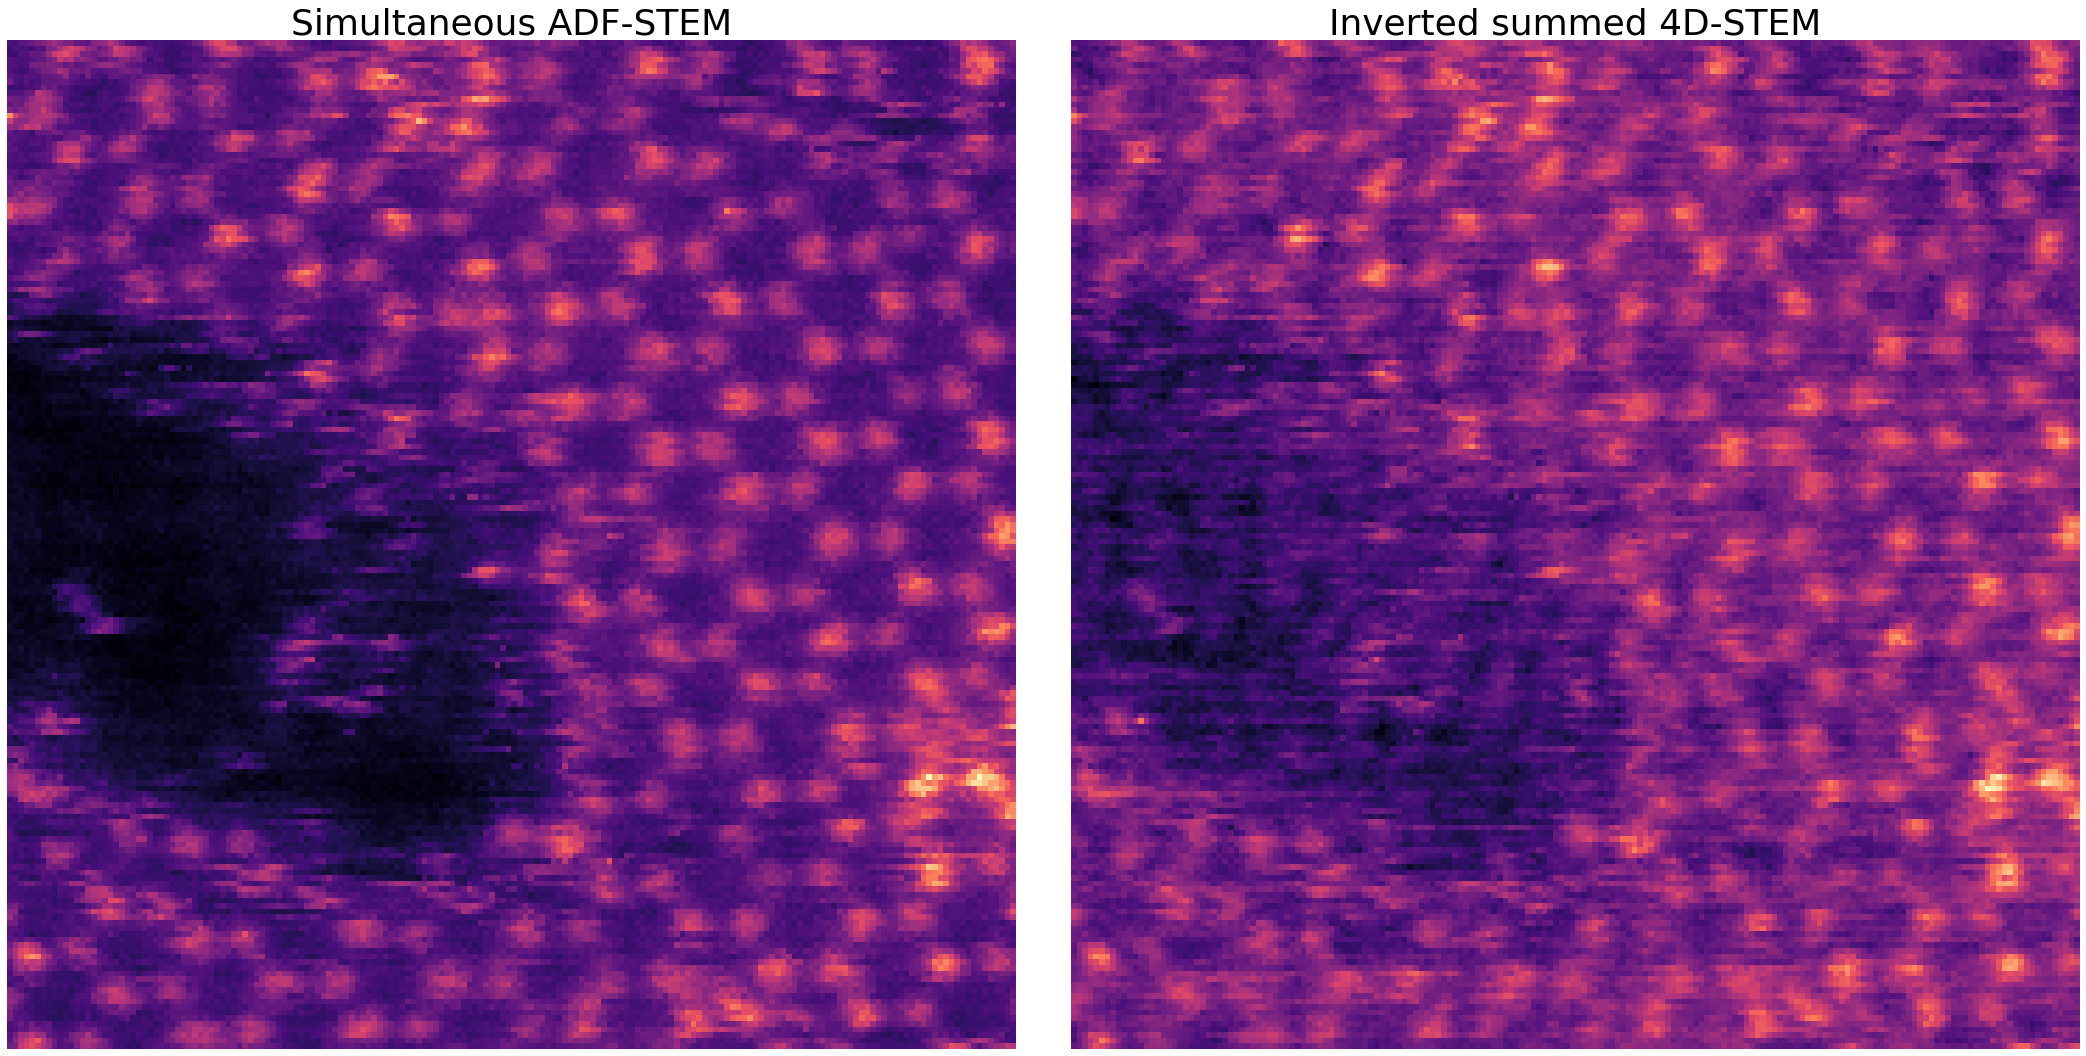

In [6]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(DataADF)
plt.axis('off')
plt.title('Simultaneous ADF-STEM')
plt.subplot(1,2,2)
plt.imshow(-np.sum(Data_4D,axis=(-1,-2)))
plt.axis('off')
plt.title('Inverted summed 4D-STEM')
plt.tight_layout()

In [7]:
Flat4D = np.reshape(Data_4D,(Data4Dshape[0]*Data4Dshape[1],Data4Dshape[2],Data4Dshape[3]))
CentralDisk = np.mean(Flat4D,axis=0)
del Data_4D

Text(0.5, 1.0, 'Diffraction Disk')

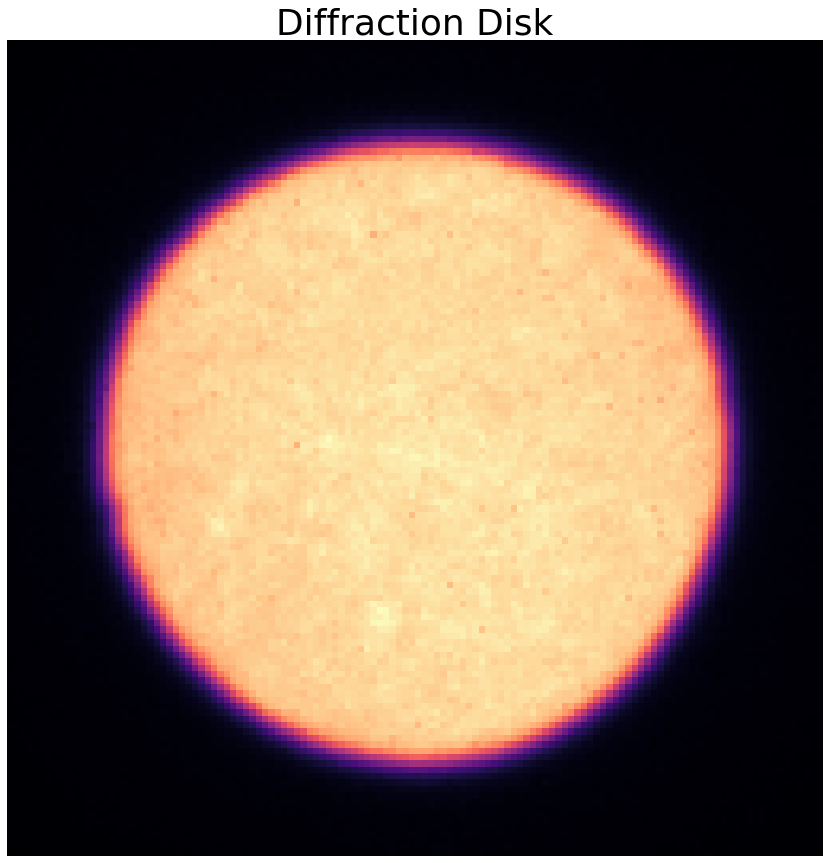

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(CentralDisk)
plt.axis('off')
plt.title('Diffraction Disk')

In [9]:
ypos,xpos = np.mgrid[0:Data4Dshape[0],0:Data4Dshape[1]]
positions = (np.asarray((np.ravel(ypos),np.ravel(xpos)),dtype=int)).transpose()

In [10]:
beam_x,beam_y,beam_r = st.util.sobel_circle(CentralDisk)

In [11]:
beam_x,beam_y,beam_r

(63.938547762157725, 63.76387221852958, 48.78737521188505)

In [20]:
%timeit centerCBED(Flat4D[0:100,:,:],beam_x,beam_y)

156 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
st.tic()
Flat4D = centerCBED(Flat4D,beam_x,beam_y)
CentralDisk = np.mean(Flat4D,axis=0)
beam_x,beam_y,beam_r = st.util.sobel_circle(CentralDisk)
st.toc()

Elapsed time: 51.824612 seconds.



In [22]:
beam_x,beam_y,beam_r

(63.999906901113725, 63.99325390360013, 48.78738858133766)

In [23]:
st.tic()
dpc_x,dpc_y = get_flat_dpc(Flat4D)
dpc_x = np.reshape(dpc_x,(1+positions[-1,0],1+positions[-1,1]))
dpc_y = np.reshape(dpc_y,(1+positions[-1,0],1+positions[-1,1]))
st.toc()

Elapsed time: 10.934941 seconds.



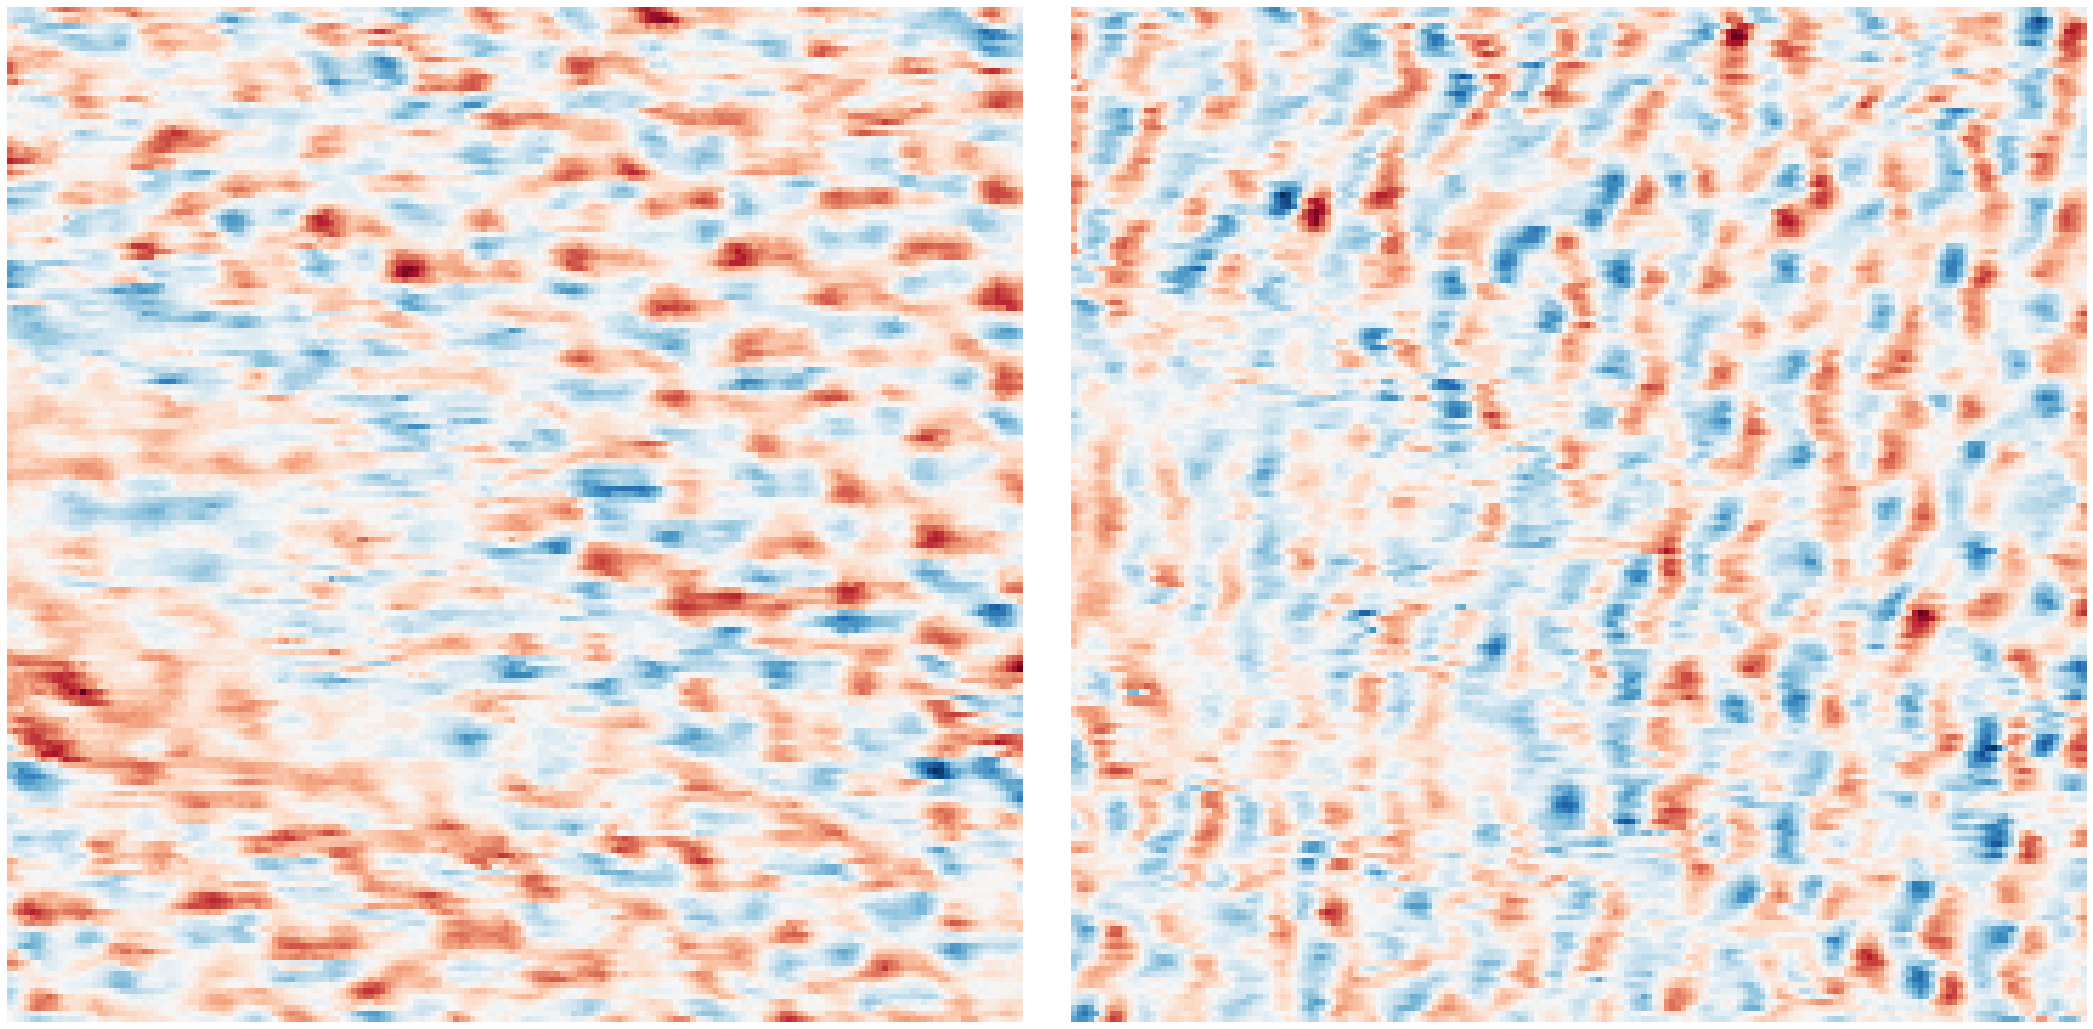

In [24]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(dpc_x,cmap='RdBu_r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dpc_y,cmap='RdBu_r')
plt.axis('off')
plt.tight_layout()

In [25]:
st.tic()
rotangle,flipval = optimize_angle(dpc_x,dpc_y,DataADF)
dpc_xC,dpc_yC = corrected_dpc(dpc_x,dpc_y,rotangle,flipval)
st.toc()

Elapsed time: 2.261274 seconds.



In [26]:
rotangle, flipval

(-101.51309598520959, False)

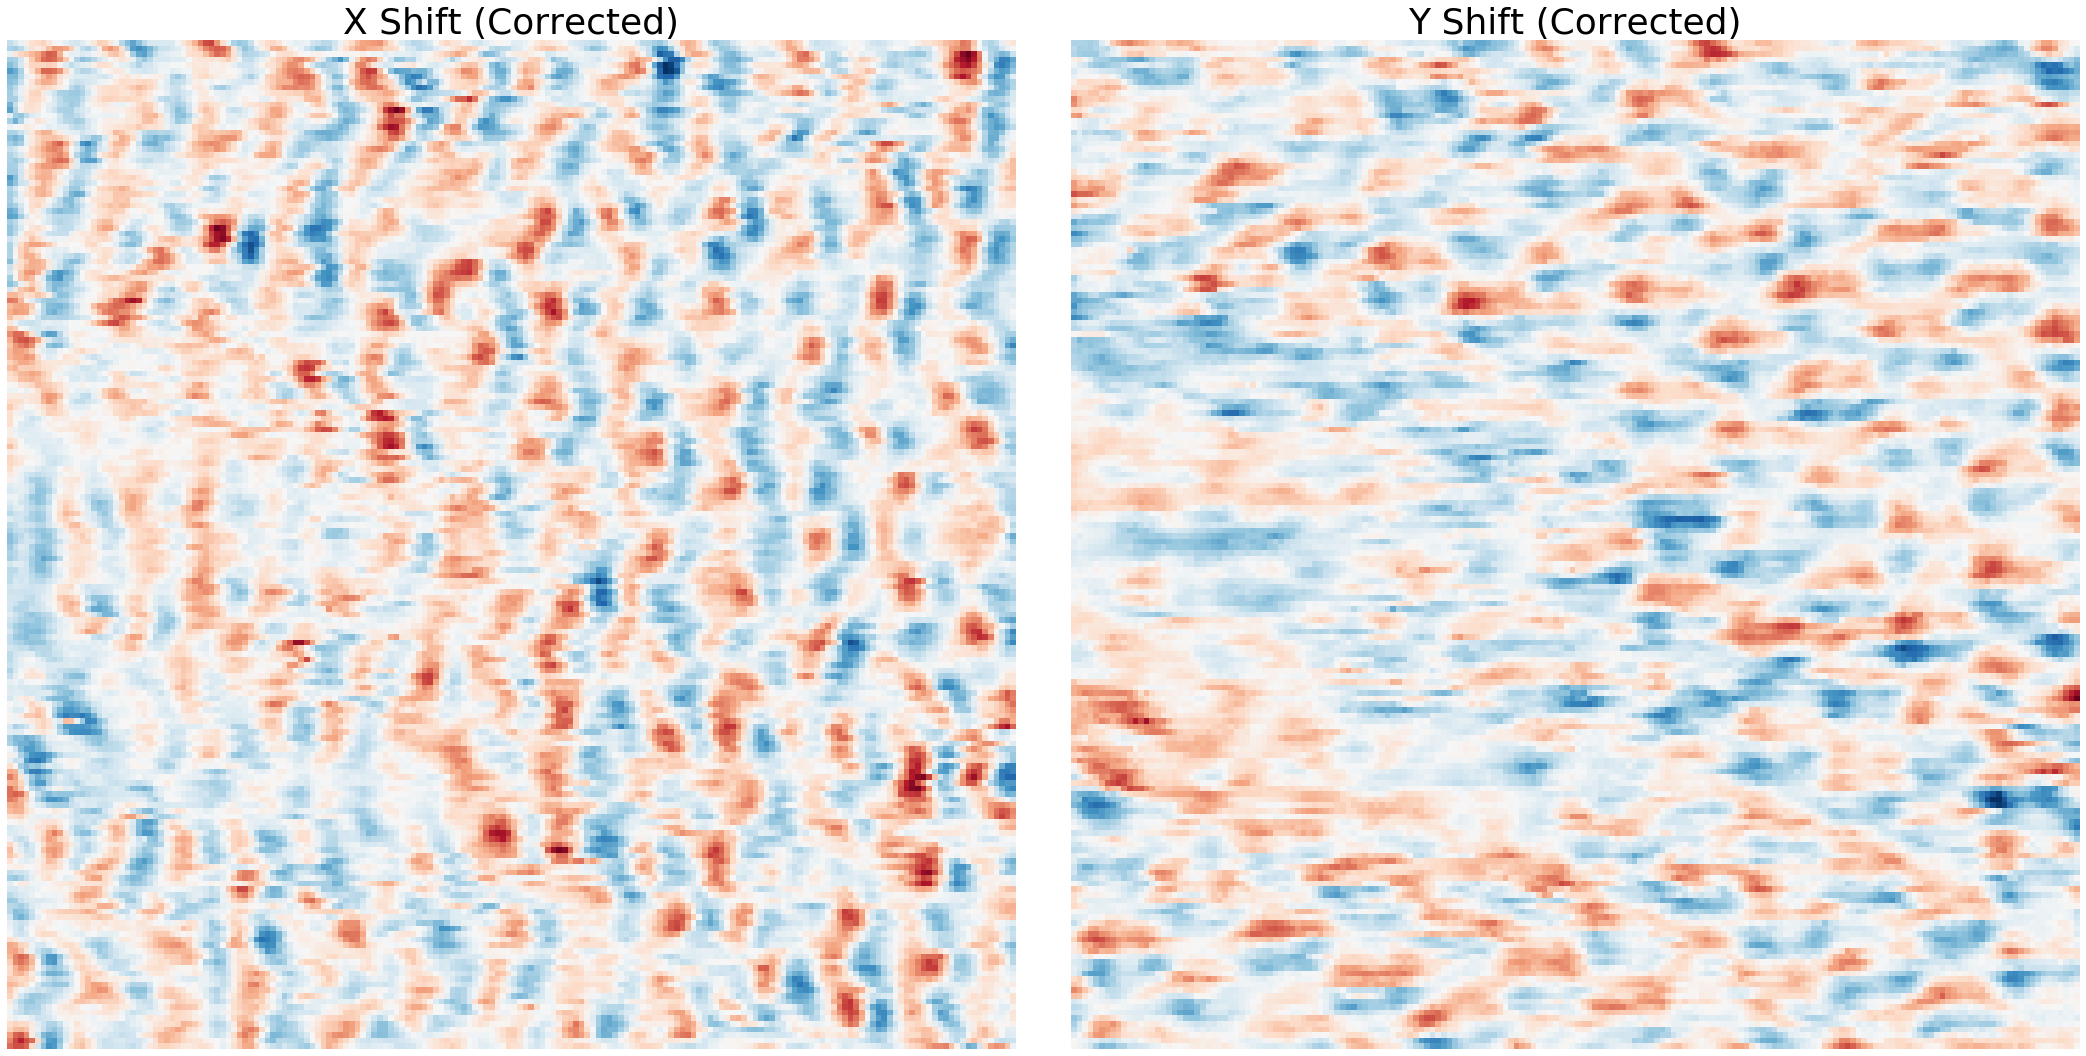

In [27]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(dpc_xC,cmap='RdBu_r')
plt.axis('off')
plt.title('X Shift (Corrected)')
plt.subplot(1,2,2)
plt.imshow(dpc_yC,cmap='RdBu_r')
plt.axis('off')
plt.title('Y Shift (Corrected)')
plt.tight_layout()

In [60]:
@numba.jit(cache=True,parallel=True)
def numba_rotator(data4D_flat,rotangle):
    data4D_rot = np.zeros_like(data4D_flat,dtype=data4D_flat.dtype)
    for ii in numba.prange(data4D_flat.shape[0]):
        data4D_rot[ii,:,:] = scnd.rotate(data4D_flat[ii,:,:],rotangle,reshape=False)
    return data4D_rot

In [32]:
%timeit scnd.rotate(Flat4D[0:100,:,:],rotangle,axes=(1,2),reshape=False)

575 ms ± 8.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%timeit numba_rotator(Flat4D[0:100,:,:],rotangle)

595 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Since `numba` here doesn't give any speedup as compared to `scipy.ndimage.rotate` that's what we will continue using

In [36]:
st.tic()
Flat4D = scnd.rotate(Flat4D,rotangle,axes=(1,2),reshape=False)
st.toc()

Elapsed time: 186.822587 seconds.



Text(0.5, 1.0, 'Rotated Diffraction Disk')

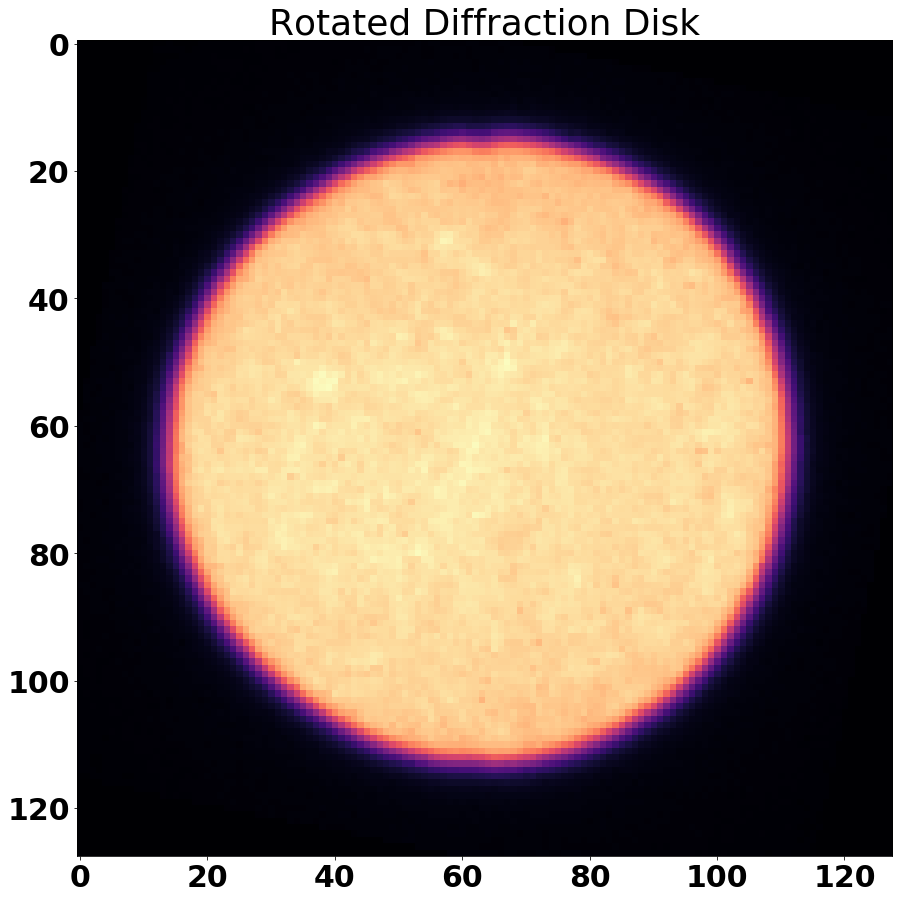

In [37]:
plt.figure(figsize=(15,15))
plt.imshow(np.mean(Flat4D,axis=0))
plt.title('Rotated Diffraction Disk')

In [38]:
calib = infoADF['spatial_calibrations'][0]['scale']
calib_pm = 1000*calib

In [39]:
st.tic()
new_dpc_x,new_dpc_y = get_flat_dpc(Flat4D)
new_dpc_x = np.reshape(new_dpc_x,(1+positions[-1,0],1+positions[-1,1]))
new_dpc_y = np.reshape(new_dpc_y,(1+positions[-1,0],1+positions[-1,1]))
st.toc()

Elapsed time: 11.379207 seconds.



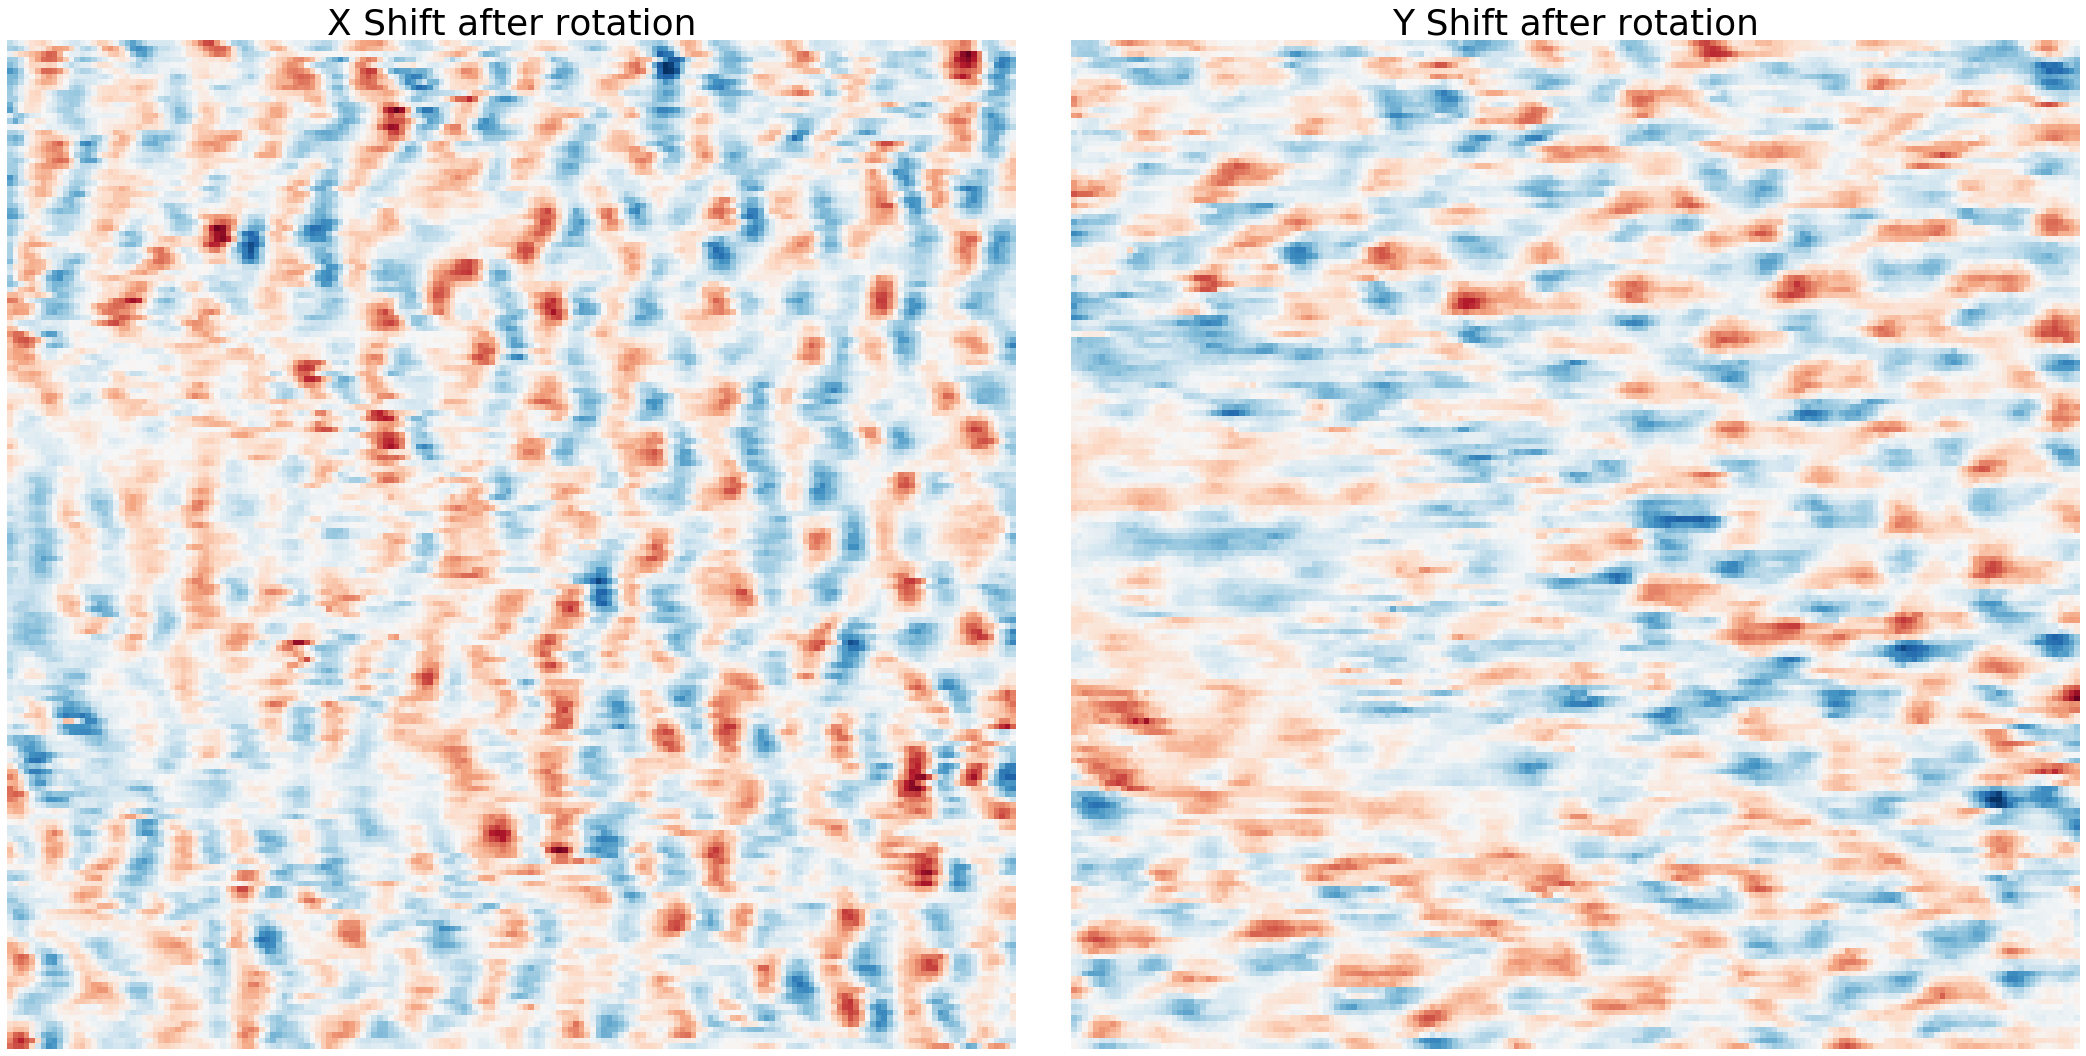

In [40]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(new_dpc_x,cmap='RdBu_r')
plt.title('X Shift after rotation')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(new_dpc_y,cmap='RdBu_r')
plt.title('Y Shift after rotation')
plt.axis('off')
plt.tight_layout()

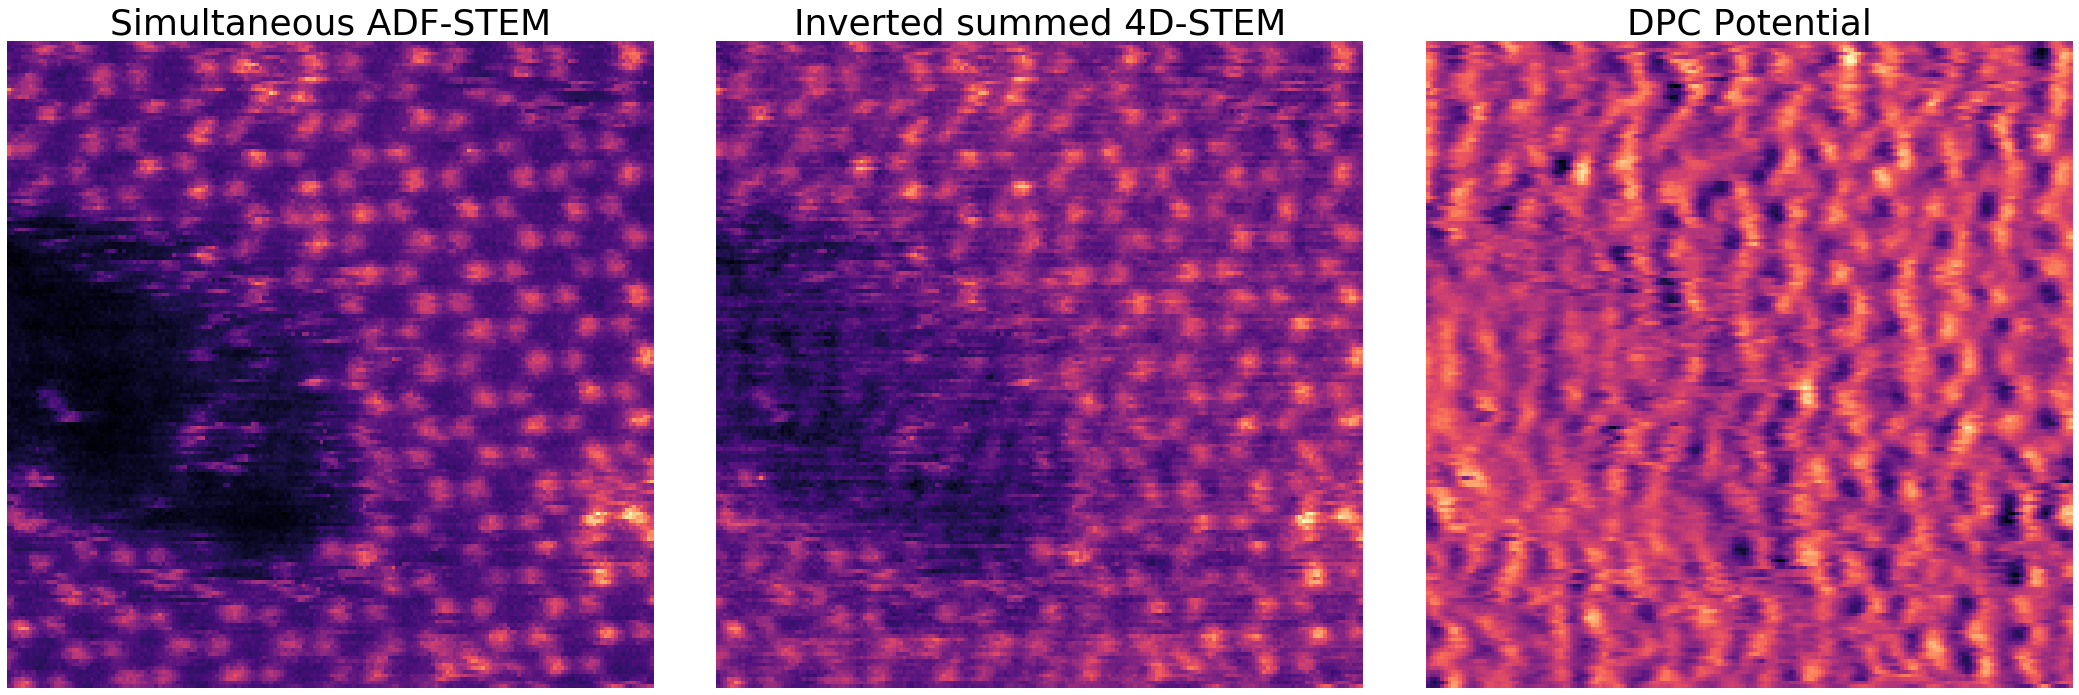

In [41]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(DataADF)
plt.axis('off')
plt.title('Simultaneous ADF-STEM')
plt.subplot(1,3,2)
plt.imshow(np.reshape((-np.sum(Flat4D,axis=(-1,-2))),(1+positions[-1,0],1+positions[-1,1])))
plt.axis('off')
plt.title('Inverted summed 4D-STEM')
plt.subplot(1,3,3)
plt.imshow(integrate_dpc(new_dpc_x,new_dpc_y))
plt.axis('off')
plt.title('DPC Potential')
plt.tight_layout()

In [42]:
aperture_sa = 31/1000
beam_calib = (aperture_sa/(100*st.beam.wavelength_ang(60)))/beam_r
beam_calib

0.00013057999969668573

In [43]:
current_size = 1+positions[-1,:]
padding = 2000 #in picometers
pad_pixels = int(padding/calib_pm)
new_size = (current_size + 2*pad_pixels).astype(int)
pad_positions = (positions + pad_pixels).astype(int)
start_psi = np.ones(new_size,dtype=np.complex64)

In [44]:
ideal_radius = (np.sum(np.abs(np.fft.fftshift(np.fft.fft2(st.beam.make_probe(1000*aperture_sa,60,new_size,calib_pm)))))/np.pi)**0.5
sampling = beam_r/ideal_radius
sampling

0.958628531795088

In [45]:
%timeit resizer4Df(Flat4D[0:100,:,:],sampling)

67.7 ms ± 771 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%timeit subpixel_pad4D(resizer4Df(Flat4D[0:100,:,:],sampling),new_size,1.1*ideal_radius)

1.84 s ± 32.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
st.tic()
Flat4D = resizer4Df(Flat4D,sampling)
Flat4D = subpixel_pad4D(Flat4D,new_size,1.1*ideal_radius)
st.toc()

Elapsed time: 553.862401 seconds.



In [49]:
Flat4D.shape

(32400, 360, 360)

Text(0.5, 1.0, 'Processed Diffraction Disk')

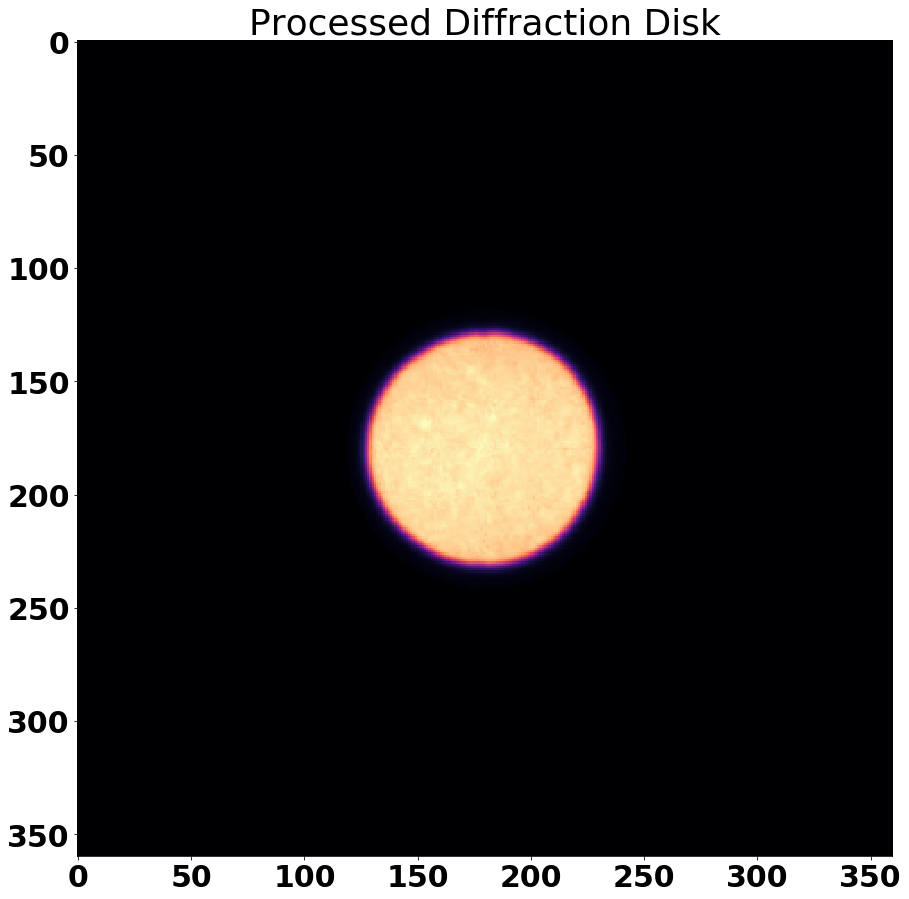

In [50]:
plt.figure(figsize=(15,15))
plt.imshow(np.mean(Flat4D,axis=0))
plt.title('Processed Diffraction Disk')

In [66]:
@numba.jit(cache=True,parallel=True)
def numba_squared(data4D_flat):
    data4D_final = np.zeros_like(data4D_flat,dtype=data4D_flat.dtype)
    temp = np.zeros(data4D_flat.shape[1:3],dtype=data4D_flat.dtype)
    data_max = np.amax(data4D_flat)
    data_min = np.amin(data4D_flat)
    data_range = data_max - data_min
    for ii in numba.prange(data4D_flat.shape[0]):
        temp = data4D_flat[ii,:,:]
        temp = (temp - data_min)/data_range
        data4D_final[ii,:,:] = temp ** 0.5
    return data4D_final

In [67]:
%timeit st.util.image_normalizer(Flat4D[0:100,:,:])**0.5

321 ms ± 6.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
%timeit numba_squared(Flat4D[0:100,:,:])

83.4 ms ± 4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Since `numba` is much faster, that's what we will use

In [69]:
st.tic()
Flat4D_sq = numba_squared(Flat4D)
st.toc()

Elapsed time: 23.283076 seconds.



Text(0.5, 1.0, 'Processed Squared Diffraction Disk')

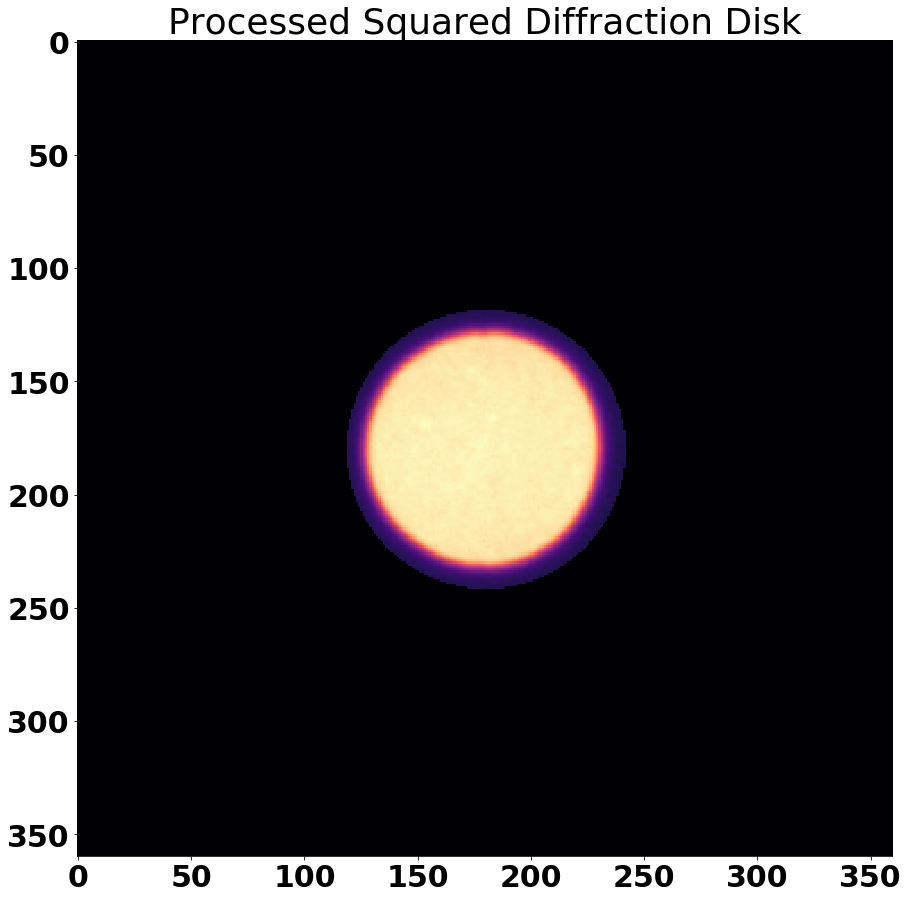

In [70]:
plt.figure(figsize=(15,15))
plt.imshow(np.mean(Flat4D_sq,axis=0))
plt.title('Processed Squared Diffraction Disk')

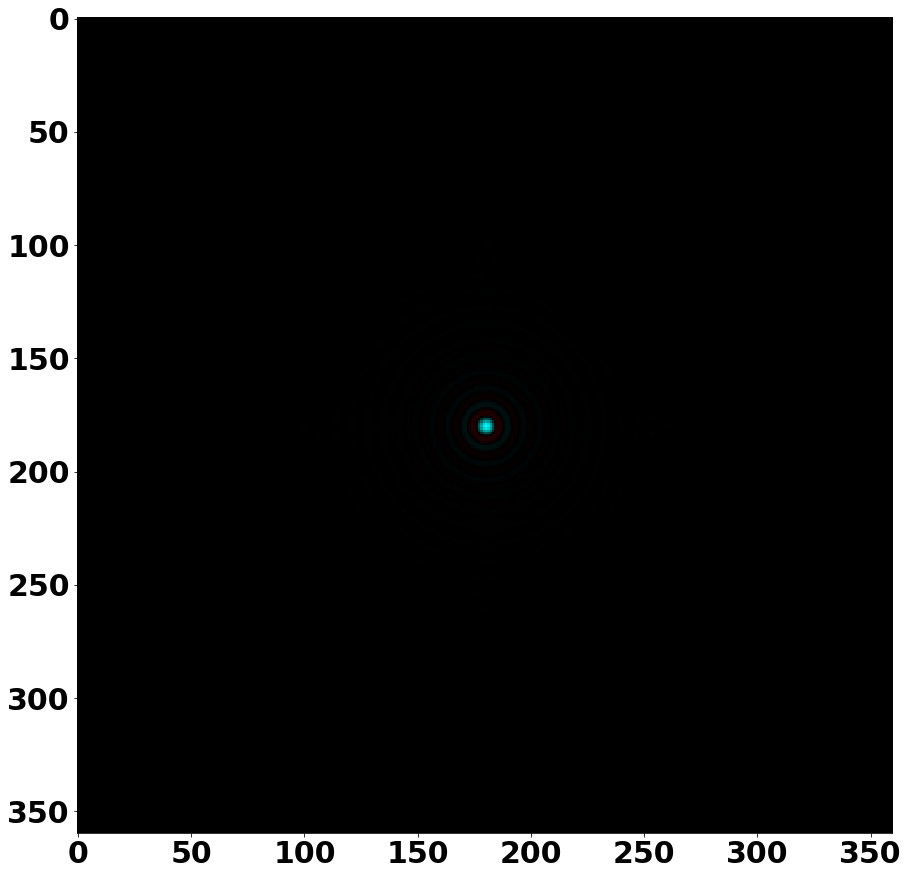

In [71]:
pure_probe = st.beam.make_probe(1000*aperture_sa,60,new_size,calib_pm)
plt.figure(figsize=(15,15))
plt.imshow(st.util.cp_image_val(pure_probe))

In [80]:
@numba.jit(cache=True,parallel=True)
def get_move_matrix(positions,im_size,probe=True):
    move_mat = np.zeros((len(positions),im_size[0],im_size[1]),dtype=np.complex64)
    image_size = np.asarray(im_size)
    fourier_cal_y = (np.linspace((-image_size[0]/2), ((image_size[0]/2) - 1), image_size[0]))/image_size[0]
    fourier_cal_x = (np.linspace((-image_size[1]/2), ((image_size[1]/2) - 1), image_size[1]))/image_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    fourier_mesh_x = (-2) * np.pi * 1j * fourier_mesh_x
    fourier_mesh_y = (-2) * np.pi * 1j * fourier_mesh_y
    if probe:
        move_pixels =  np.fliplr(positions) - np.flip(image_size/2)
    else:
        move_pixels =  np.flip(image_size/2) - np.fliplr(positions)
    for ii in numba.prange(len(positions)):
        move_mat[ii,:,:] = np.exp((fourier_mesh_x*move_pixels[ii,0]) + (fourier_mesh_y*move_pixels[ii,1]))
    return move_mat

def move_prb_obj(probe,move_mat):
    mp = (np.fft.ifft2((move_mat*np.fft.fft2(probe)),axes=(-1,-2))).astype(np.complex64)
    return mp

In [82]:
%timeit get_move_matrix(pad_positions[0:50,:],new_size)

134 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
st.tic()
prb_mover = get_move_matrix(pad_positions,new_size)
obj_mover = get_move_matrix(pad_positions,new_size,probe=False)
st.toc()

In [ ]:
st.tic()
moved_probe = move_prb_obj(pure_probe,prb_mover)
st.toc()

In [41]:
st.tic()
psi_old = np.fft.fftshift(np.fft.fft2(moved_probe*start_psi,axes=(-1,-2)),axes=(-1,-2))
st.toc()

Elapsed time: 223.202567 seconds.



`psi_old` calculated this way is in the *Fourier* plane

In [42]:
st.tic()
psi_new = np.fft.ifftshift(np.fft.ifft2((Flat4D_sq*np.exp((1j)*np.angle(psi_old))),axes=(-1,-2)),axes=(-1,-2))
st.toc()

Elapsed time: 1084.169118 seconds.



`psi_new` calculated this way is in the *Imaging* plane, so to calculate `psi_diff` we need to backpropagate `psi_old` to the imaging plane